In [1]:
import numpy as np
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt
import pickle

# Definition of possible sequences of actions and calculation of expected rewards
This script finds all possible sequences of actions given the task design. (Until now, it just works for square grids). This result is saved. Based on these sequences of actions, the grid pattern, and the trial goals expected rewards are calculated.

Goal matching task: The grid has a size of 5x5. Each sequence of actions contains of exactly four moves. The agent always starts in the middle of the grid. It is not possible to revisit fields or to leave the grid. Three moves are possible: straight down, diagonal up left, and diagonal up right. The task comprises 16 blocks with 20 trials each. A different grid pattern is used for each block. Also trial goals change trial-wise. The expected reward is defined by the difference between the trial goals and the sum of the collected points. At the end also the goal points sets are plotted.

## Define possible policies and the fields of the policies

In [2]:
nMoves = 4 # number of moves
moves = np.array([[-1,-1],[1,0],[-1,1]]) # up left diagonal, down straight, up right diagonal

gridSize = np.array([5,5]) # define the size of the grid
initialPosition = np.array([2,2]) # define the initial positions for the trials

# define possible sequences of actions (irrespective if they are possible)
sequences = np.array(list(product(np.arange(len(moves)), repeat=nMoves)))

In [3]:
# translate moves into positions inside the grid

# preallocation:
# - set all to the initial position of the trials
# - add one move to store the initial position
sequencePos = np.tile(initialPosition, len(sequences)*(nMoves+1)).reshape(len(sequences), -1, 2)

In [4]:
# add the moves in terms of shift of the field position
sequencePos[:,1:] = moves[sequences]

# use cumsum to get the grid positions after each move
sequencePos = np.cumsum(sequencePos, axis=1)

In [5]:
# delete impossible sequences of actions
sequenceMask = np.ones(len(sequences), dtype=bool) # preallocation

# loop over all sequences
for p in range(len(sequences)):

    # get unique positions of the sequence
    uniquePositions = np.unique(sequencePos[p], axis=0)

    # check if sequence leaves the grid
    if min(np.unique(sequencePos[p]))<0 or max(np.unique(sequencePos[p]))>np.max(gridSize-1):
        sequenceMask[p] = False
    # check if sequence revisits one field
    elif len(uniquePositions)<nMoves+1:
        sequenceMask[p] = False

In [6]:
# apply mask to delete impossible sequences
sequencePos = sequencePos[sequenceMask]
sequences = sequences[sequenceMask]

In [7]:
f = open('sequences.pkl', 'wb')
pickle.dump(sequences, f) #sequencePos]
f.close()

## Calculate expected rewards
### calculate the summed points for each sequence of actions based for each grid pattern (i.e. block)

In [8]:
# load grid patterns
gridPatterns = np.genfromtxt('grid_patterns.csv', delimiter=',')

In [9]:
# calculate the points for each sequence for each grid pattern
sequencePoints = np.zeros((len(gridPatterns), len(sequences))) # preallocation

# loop over grids
for gridID, grid in enumerate(gridPatterns):
    grid = np.reshape(grid, gridSize) # reshape from vector to 2D matrix
    
    # loop over sequences of actions
    for seqID, seq in enumerate(sequencePos):
        sequencePoints[gridID, seqID] = np.sum(grid[seq[:,0],seq[:,1]]) # sum points and save

### get the vector with the trial goals based on the goal sets (drifts)

In [10]:
# define the four different goal drifts
drifts = np.array([[ 1, 0, -1, -1,  2,  2,  2,  3,  1,  4,  9, 12, 14,15, 17, 15, 11, 8, 6, 5], 
                    [-1,  2, -1,  2,  9,  8, 12, 17, 20, 20, 22, 18, 18,20, 21, 23, 20, 17, 18, 15],
                    [ 2, -2, -4, -4, 0, 0,  6,  6,  5,  4,  7, 11, 13,12, 16, 12, 16, 20, 21, 24], 
                    [ 3,  2,  7, 11, 12,  7,  5,  4,  2,  5,  8,  6,  2,  2,  1, -2, -6, -8, -5, -3]])

# add also the opposite of each drift
drifts = np.concatenate([drifts, drifts*-1])

# define the assignment of drifts to blocks
driftIDs = np.array([4, 6, 7, 1, 6, 0, 3, 5, 4, 2, 3, 1, 7, 5, 0, 2])

In [11]:
# get the goals for all trials
goals = drifts[driftIDs].flatten()

### save csv with task structure (incl. goal and bonus trial indicator)

In [12]:
dfTaskStructure = pd.DataFrame()
dfTaskStructure['trial'] = np.arange(len(goals))
dfTaskStructure['block'] = np.arange(len(driftIDs)).repeat(drifts.shape[1])
dfTaskStructure['goal'] = goals
dfTaskStructure['bonus'] = bonusBlocks = np.array([1,0,0,1,1,0,1,0,1,1,0,0,1,1,0,0]).repeat(drifts.shape[1])

In [13]:
dfTaskStructure.to_csv('task_structure.csv')

### calculate the expected rewards for each trial
$\text{reward}=\max\{0,100-2\cdot|\text{goal}-\text{points}|\}$

In [14]:
# create the block structure of the task -> which grid has to be used at each trial
nBlocks = len(gridPatterns) # number of blocks equals the number of grid patterns
nTrialPerBlock = len(goals)/nBlocks # get the number of trials per block

trialBlockMapping = np.repeat(np.arange(nBlocks), nTrialPerBlock) # indicates the block number of each trial

In [15]:
# calculate the expected reward for all sequences at each trial
expectedRewards = np.zeros((len(goals), len(sequences))) # preallocation

In [16]:
for t, goal in enumerate(goals):
    expectedRewards[t] = 100-2*np.abs(sequencePoints[trialBlockMapping[t]]-goal)

expectedRewards[expectedRewards<0] = 0 # max(0, expected reward)

In [17]:
# add the probabilistic bonus to the expected reward of the DAS 
bonusBlocks = np.array([1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0]) # indicate the blocks with probabilistic bonus
bonusTrials = np.repeat(bonusBlocks, nTrialPerBlock) # get the bonus trials

dasID = 4 # define the index of the DAS
pBonus = .25 # probability of getting the bonus
valueBonus = 20 # points of the bonus

# add the probabilistic bonus to all bonus trials for the DAS
expectedRewards[np.bool_(bonusTrials), dasID] = expectedRewards[np.bool_(bonusTrials), dasID] + pBonus*valueBonus

In [18]:
# save it
np.savetxt('trial_sequence_rewards.csv', expectedRewards, delimiter=',')

## Plot the drifts

In [20]:
import seaborn as sns
import sys
import matplotlib as mpl

In [29]:
# load file with plotting stlye definitions
sys.path.append('../')
plt.style.use('plotting_style.mpltstyle')

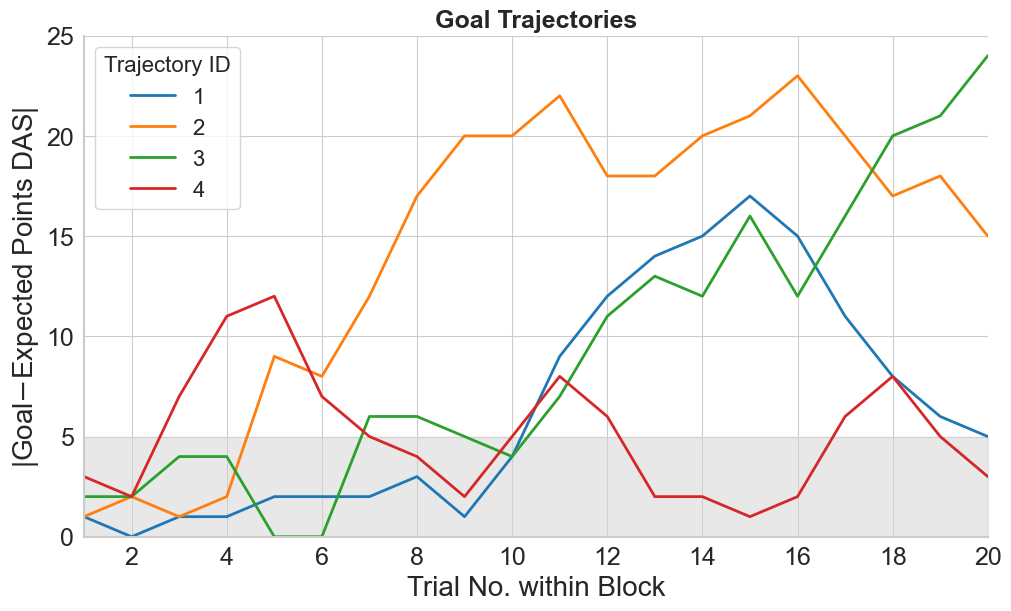

In [33]:
sns.set_style('whitegrid')
plt.figure(layout='constrained')
for drift in range(len(drifts[:4])):
    plt.plot(np.abs(drifts[drift]), lw=2)
plt.ylabel('|Goal$ - $Expected Points DAS|', fontsize=20)
plt.xlabel('Trial No. within Block', fontsize=20)
plt.xticks(np.arange(1,20,2), np.arange(2,21,2))
plt.fill_between(x=[0,19], y1=0, y2=5, color='lightgrey', alpha=.5)
plt.title('Goal Trajectories', fontsize=18, fontweight='bold')
plt.ylim([0,25])
plt.xlim([0,19])
plt.legend(np.arange(1,5), title='Trajectory ID', fontsize=16, title_fontsize=16)
sns.despine()

plt.savefig('drifts.svg', format='svg') #, bbox_inches='tight')

plt.show()

In [25]:
# print date of last changes and version numbers
%load_ext watermark

%watermark -n -u -v -iv -w

Last updated: Tue Mar 26 2024

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.10.0

matplotlib: 3.7.0
pandas    : 1.5.3
numpy     : 1.24.2

Watermark: 2.3.1

